# Binary-Class Tabular Model for Pistachio Identification Using Python and Scikit-Learn
### David Lowe
### July 18, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Pistachio Identification dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Pistachio nut has an important place in the agricultural economy; the efficiency of post-harvest industrial processes is crucial to maintaining its economic value. The industry needs new methods and technologies for separating and classifying pistachios to provide this efficiency. In this study, the research team aimed to develop a classification model different from traditional separation methods based on image processing and artificial intelligence techniques.

A computer vision system (CVS) has been developed to distinguish two species of pistachios with different characteristics that address additional market types. The research team took 2148 sample images for these two kinds of pistachios with a high-resolution camera. They applied image processing, segmentation, and feature extraction techniques to the images of the pistachio samples.

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 88.65% using the training dataset. Furthermore, we selected Extra Trees as the final model as it processed the training dataset with a final accuracy score of 90.21%. When we processed the test dataset with the final model, the model achieved an accuracy score of 89.53%.

CONCLUSION: In this iteration, the Extra Trees model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Pistachio Dataset

Dataset ML Model: Binary classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.23751/pn.v23i2.9686

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'Pistachio_28_Features_Dataset.arff'

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-pistachio-datasets/Tabular_Image_Datasets/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.arff'
colNames = ['Area','Perimeter','MajorAxis','MinorAxis','Eccentricity','Eqdiasq','Solidity',
            'Convex_Area','Extent','Aspect_Ratio','Roundness','Compactness','ShapeFactor1','ShapeFactor2',
            'ShapeFactor3','ShapeFactor4','Mean_RR','Mean_RG','Mean_RB','StdDev_RR','StdDev_RG',
            'StdDev_RB','Skew_RR','Skew_RG','Skew_RB','Kurtosis_RR','Kurtosis_RG','Kurtosis_RB',
            'Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=42)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area  Perimeter  MajorAxis  MinorAxis  Eccentricity   Eqdiasq  Solidity  \
0  63391   1568.405   390.3396   236.7461        0.7951  284.0984    0.8665   
1  68358   1942.187   410.8594   234.7525        0.8207  295.0188    0.8765   
2  73589   1246.538   452.3630   220.5547        0.8731  306.0987    0.9172   
3  71106   1445.261   429.5291   216.0765        0.8643  300.8903    0.9589   
4  80087   1251.524   469.3783   220.9344        0.8823  319.3273    0.9657   

   Convex_Area  Extent  Aspect_Ratio  ...  StdDev_RR  StdDev_RG  StdDev_RB  \
0        73160  0.6394        1.6488  ...    17.7206    19.6024    21.1342   
1        77991  0.6772        1.7502  ...    26.7061    27.2112    25.1035   
2        80234  0.7127        2.0510  ...    19.0129    20.0703    20.7006   
3        74153  0.7028        1.9879  ...    18.1773    18.7152    29.7883   
4        82929  0.7459        2.1245  ...    23.4298    24.0878    23.1157   

   Skew_RR  Skew_RG  Skew_RB  Kurtosis_RR  Kurtosis_RG  

In [8]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          2148 non-null   int64  
 1   Perimeter     2148 non-null   float64
 2   MajorAxis     2148 non-null   float64
 3   MinorAxis     2148 non-null   float64
 4   Eccentricity  2148 non-null   float64
 5   Eqdiasq       2148 non-null   float64
 6   Solidity      2148 non-null   float64
 7   Convex_Area   2148 non-null   int64  
 8   Extent        2148 non-null   float64
 9   Aspect_Ratio  2148 non-null   float64
 10  Roundness     2148 non-null   float64
 11  Compactness   2148 non-null   float64
 12  ShapeFactor1  2148 non-null   float64
 13  ShapeFactor2  2148 non-null   float64
 14  ShapeFactor3  2148 non-null   float64
 15  ShapeFactor4  2148 non-null   float64
 16  Mean_RR       2148 non-null   float64
 17  Mean_RG       2148 non-null   float64
 18  Mean_RB       2148 non-null 

In [9]:
print(df_dataset_import.describe())

                Area    Perimeter    MajorAxis    MinorAxis  Eccentricity  \
count    2148.000000  2148.000000  2148.000000  2148.000000   2148.000000   
mean    79950.655493  1425.971751   446.248968   238.311842      0.840219   
std     13121.737799   375.565503    32.445304    30.310695      0.048759   
min     29808.000000   858.363000   320.344500   133.509600      0.504900   
25%     71936.750000  1170.996250   426.508750   217.875825      0.817500   
50%     79905.500000  1262.785500   448.574750   236.416350      0.849650   
75%     89030.500000  1607.906250   468.509400   257.760150      0.875200   
max    124008.000000  2755.049100   541.966100   383.046100      0.946000   

           Eqdiasq     Solidity    Convex_Area       Extent  Aspect_Ratio  \
count  2148.000000  2148.000000    2148.000000  2148.000000   2148.000000   
mean    317.919173     0.940093   85015.839851     0.716067      1.898154   
std      26.908600     0.050452   13154.919327     0.052532      0.240100  

In [10]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area            0
Perimeter       0
MajorAxis       0
MinorAxis       0
Eccentricity    0
Eqdiasq         0
Solidity        0
Convex_Area     0
Extent          0
Aspect_Ratio    0
Roundness       0
Compactness     0
ShapeFactor1    0
ShapeFactor2    0
ShapeFactor3    0
ShapeFactor4    0
Mean_RR         0
Mean_RG         0
Mean_RB         0
StdDev_RR       0
StdDev_RG       0
StdDev_RB       0
Skew_RR         0
Skew_RG         0
Skew_RB         0
Kurtosis_RR     0
Kurtosis_RG     0
Kurtosis_RB     0
Class           0
dtype: int64
Total number of NaN in the dataframe:  0


In [11]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
dtype: int64


### 1.d) Data Cleaning

In [12]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area  Perimeter  MajorAxis  MinorAxis  Eccentricity   Eqdiasq  Solidity  \
0  63391   1568.405   390.3396   236.7461        0.7951  284.0984    0.8665   
1  68358   1942.187   410.8594   234.7525        0.8207  295.0188    0.8765   
2  73589   1246.538   452.3630   220.5547        0.8731  306.0987    0.9172   
3  71106   1445.261   429.5291   216.0765        0.8643  300.8903    0.9589   
4  80087   1251.524   469.3783   220.9344        0.8823  319.3273    0.9657   

   Convex_Area  Extent  Aspect_Ratio  ...  StdDev_RR  StdDev_RG  StdDev_RB  \
0        73160  0.6394        1.6488  ...    17.7206    19.6024    21.1342   
1        77991  0.6772        1.7502  ...    26.7061    27.2112    25.1035   
2        80234  0.7127        2.0510  ...    19.0129    20.0703    20.7006   
3        74153  0.7028        1.9879  ...    18.1773    18.7152    29.7883   
4        82929  0.7459        2.1245  ...    23.4298    24.0878    23.1157   

   Skew_RR  Skew_RG  Skew_RB  Kurtosis_RR  Kurtosis_RG  

In [13]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          2148 non-null   int64  
 1   Perimeter     2148 non-null   float64
 2   MajorAxis     2148 non-null   float64
 3   MinorAxis     2148 non-null   float64
 4   Eccentricity  2148 non-null   float64
 5   Eqdiasq       2148 non-null   float64
 6   Solidity      2148 non-null   float64
 7   Convex_Area   2148 non-null   int64  
 8   Extent        2148 non-null   float64
 9   Aspect_Ratio  2148 non-null   float64
 10  Roundness     2148 non-null   float64
 11  Compactness   2148 non-null   float64
 12  ShapeFactor1  2148 non-null   float64
 13  ShapeFactor2  2148 non-null   float64
 14  ShapeFactor3  2148 non-null   float64
 15  ShapeFactor4  2148 non-null   float64
 16  Mean_RR       2148 non-null   float64
 17  Mean_RG       2148 non-null   float64
 18  Mean_RB       2148 non-null 

In [14]:
print(df_dataset_import.describe())

                Area    Perimeter    MajorAxis    MinorAxis  Eccentricity  \
count    2148.000000  2148.000000  2148.000000  2148.000000   2148.000000   
mean    79950.655493  1425.971751   446.248968   238.311842      0.840219   
std     13121.737799   375.565503    32.445304    30.310695      0.048759   
min     29808.000000   858.363000   320.344500   133.509600      0.504900   
25%     71936.750000  1170.996250   426.508750   217.875825      0.817500   
50%     79905.500000  1262.785500   448.574750   236.416350      0.849650   
75%     89030.500000  1607.906250   468.509400   257.760150      0.875200   
max    124008.000000  2755.049100   541.966100   383.046100      0.946000   

           Eqdiasq     Solidity    Convex_Area       Extent  Aspect_Ratio  \
count  2148.000000  2148.000000    2148.000000  2148.000000   2148.000000   
mean    317.919173     0.940093   85015.839851     0.716067      1.898154   
std      26.908600     0.050452   13154.919327     0.052532      0.240100  

In [15]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area            0
Perimeter       0
MajorAxis       0
MinorAxis       0
Eccentricity    0
Eqdiasq         0
Solidity        0
Convex_Area     0
Extent          0
Aspect_Ratio    0
Roundness       0
Compactness     0
ShapeFactor1    0
ShapeFactor2    0
ShapeFactor3    0
ShapeFactor4    0
Mean_RR         0
Mean_RG         0
Mean_RB         0
StdDev_RR       0
StdDev_RG       0
StdDev_RB       0
Skew_RR         0
Skew_RG         0
Skew_RB         0
Kurtosis_RR     0
Kurtosis_RG     0
Kurtosis_RB     0
target          0
dtype: int64
Total number of NaN in the dataframe:  0


In [16]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
dtype: int64


### 1.e) Splitting Data into Sets

In [17]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (2148, 29) df_features_import.shape: (2148, 28) df_target_import.shape: (2148,)


In [18]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (1718, 28) df_target_train.shape: (1718,)
df_features_test.shape: (430, 28) df_target_test.shape: (430,)


### 1.f) Set up the parameters for data visualization

In [19]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [20]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

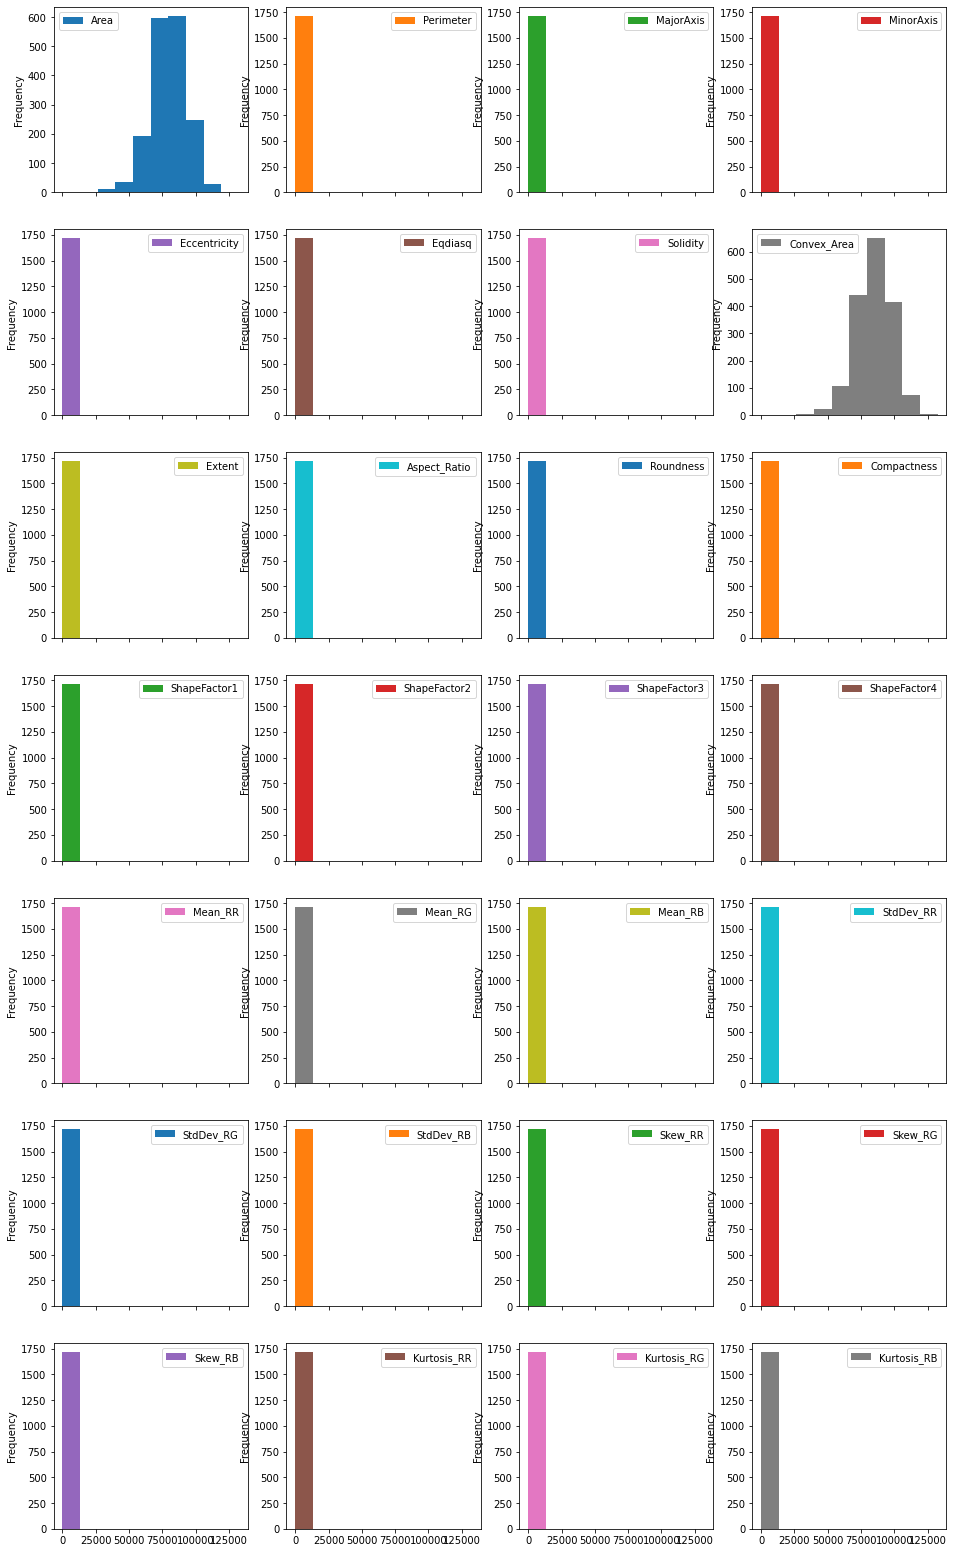

In [22]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

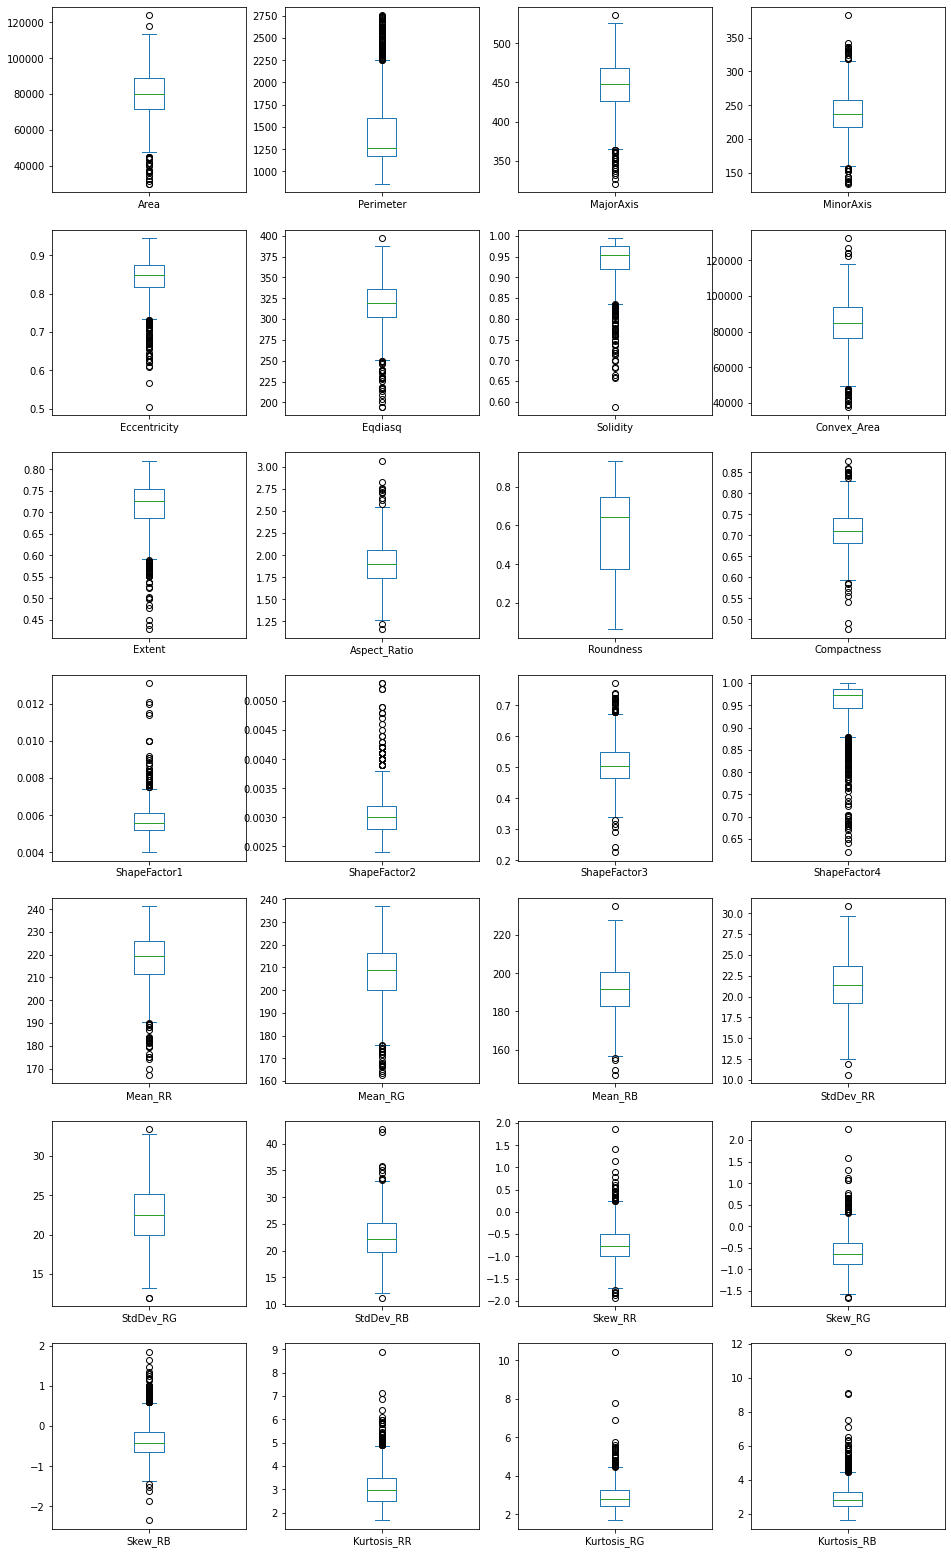

In [23]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

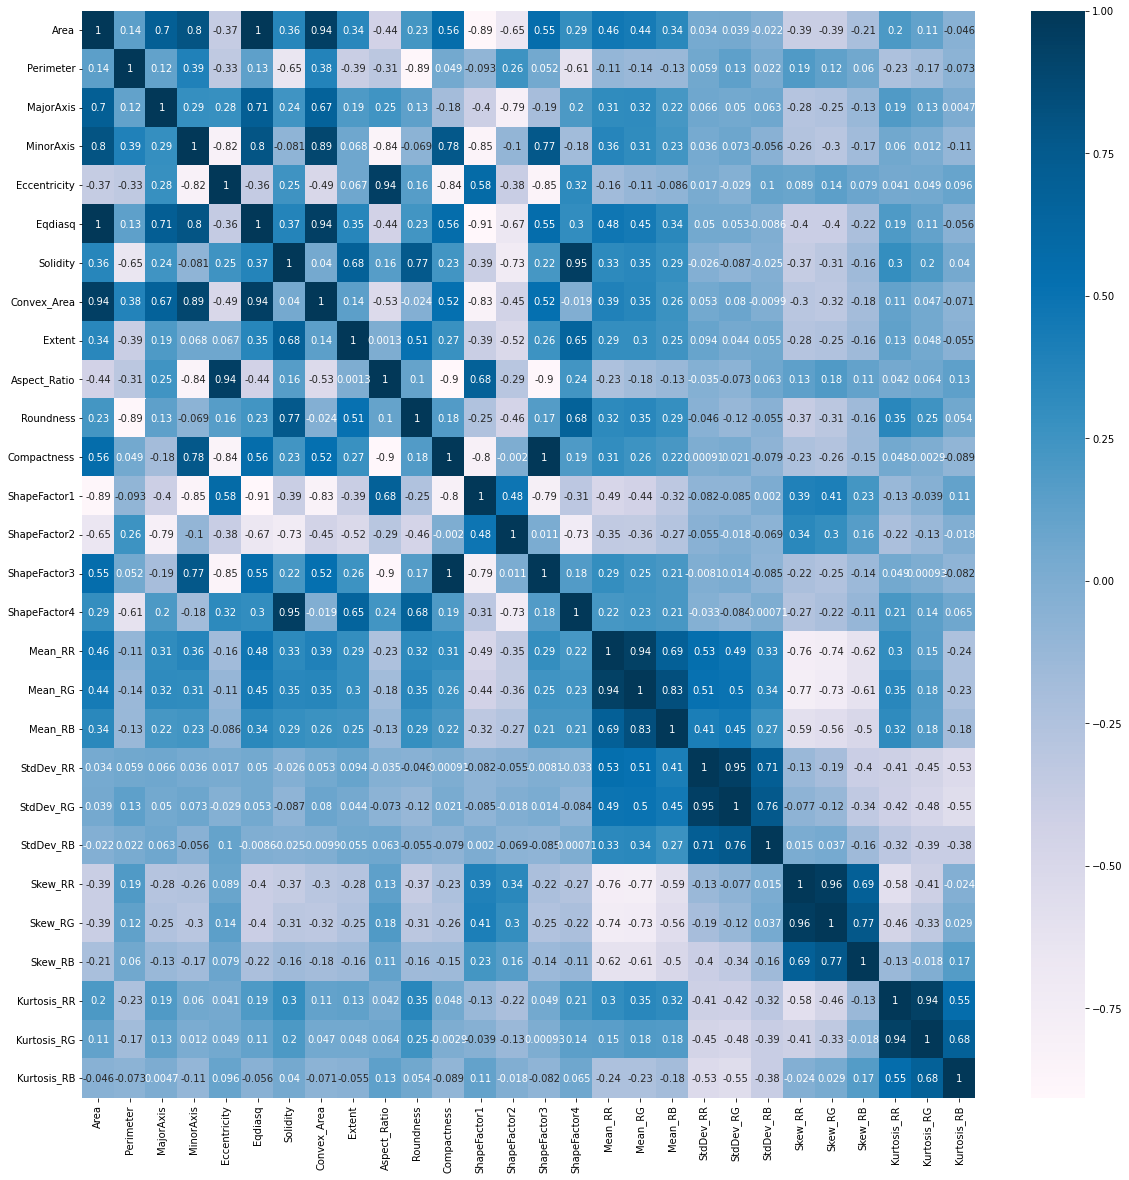

In [24]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [25]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [27]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 28
Number of categorical columns: 0
Total number of columns in the feature dataframe: 28


In [28]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

### 3.b) Training Data Balancing

In [29]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [30]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [31]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
# array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (1718, 28) array_target_train.shape: (1718,)


In [32]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [33]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [34]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [35]:
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [36]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm", name, "modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

LGR: 0.899278 (0.016677)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



LogisticRegression(n_jobs=1, random_state=888)
Model training time: 0:00:00.143716 

CART: 0.840489 (0.020131)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:00.183617 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN: 0.892303 (0.009896)
KNeighborsClassifier(n_jobs=1)
Model training time: 0:00:00.116117 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BGT: 0.888231 (0.015960)
BaggingClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:00.994656 



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RNF: 0.896944 (0.024995)
RandomForestClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:02.191971 

EXT: 0.902183 (0.023016)
ExtraTreesClassifier(n_jobs=1, random_state=888)
Model training time: 0:00:00.918964 

Average metrics (accuracy) from all models: 0.8865714059710262
Total training time for all models: 0:00:04.588305


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


### 4.b) Spot-checking baseline algorithms

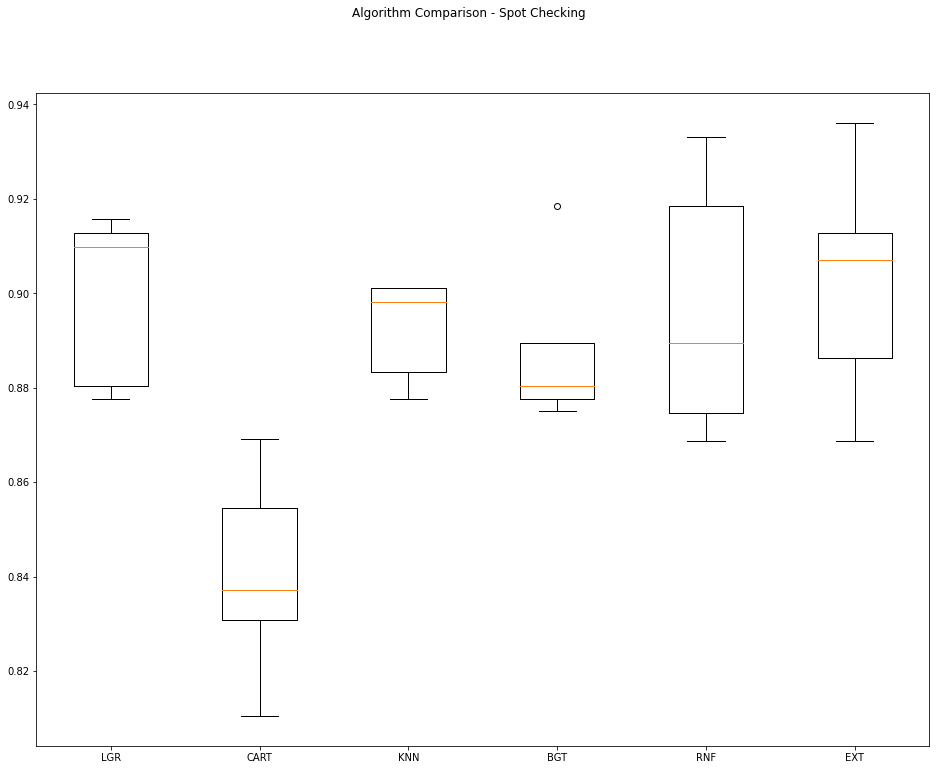

In [37]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning algorithm #1
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = KNeighborsClassifier(n_jobs=N_JOBS)
tune_model_names.append('KNN')
paramGrid1 = dict(n_neighbors=np.array([3, 5, 10]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.899871 using {'n_neighbors': 3}
0.899871 (0.012659) with: {'n_neighbors': 3}
0.892303 (0.009896) with: {'n_neighbors': 5}
0.890555 (0.015468) with: {'n_neighbors': 10}
Model training time: 0:00:00.361900


In [41]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_neighbors = 3


In [42]:
# Tuning algorithm #2
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('EXT')
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.902183 using {'n_estimators': 100}
0.902183 (0.023016) with: {'n_estimators': 100}
0.901595 (0.027458) with: {'n_estimators': 300}
0.899849 (0.026341) with: {'n_estimators': 500}
Model training time: 0:00:08.408931


In [43]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 100


### 4.d) Compare Algorithms After Tuning

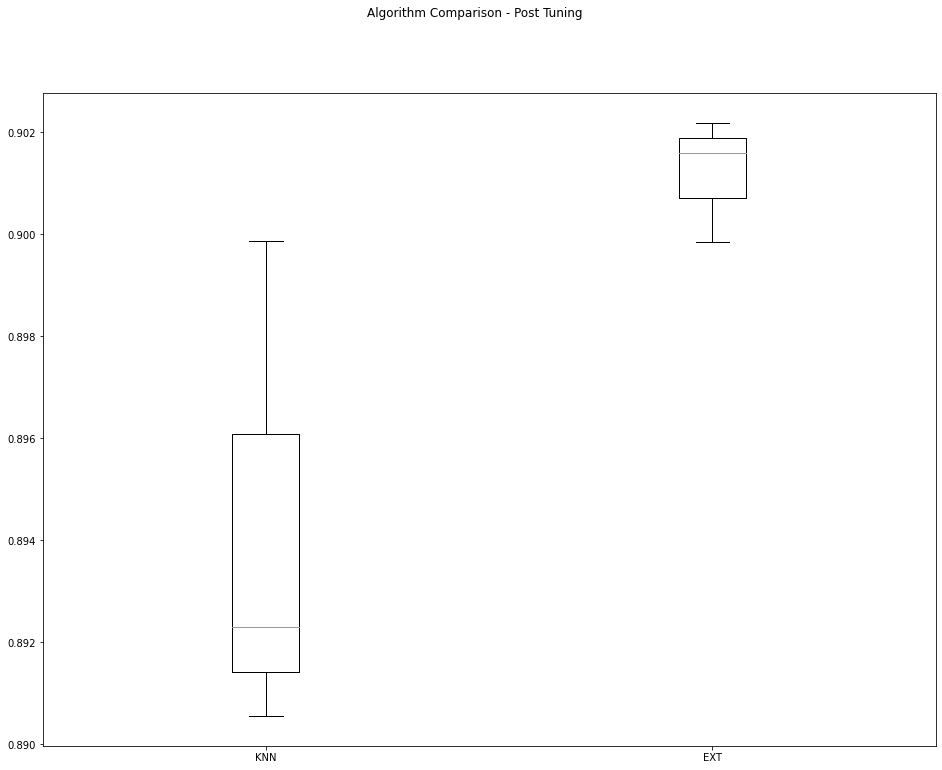

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [47]:
final_model = ExtraTreesClassifier(n_estimators=best_paramValue2, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

ExtraTreesClassifier(n_jobs=1, random_state=888)


### 5.b) Load Test Dataset and Make Predictions

In [48]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = label_encoder.transform(df_target_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (430, 28) to array_features_test.shape: (430, 28)


In [49]:
# Make batched predictions
# test_predictions =  label_encoder.inverse_transform(np.argmax(final_model.predict(array_features_test), axis=-1))
# test_predictions =  label_encoder.inverse_transform(final_model.predict(array_features_test))
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1
 1 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1
 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1
 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1
 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0
 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1
 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0]


In [50]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.8953488372093024
[[223  24]
 [ 21 162]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       247
           1       0.87      0.89      0.88       183

    accuracy                           0.90       430
   macro avg       0.89      0.89      0.89       430
weighted avg       0.90      0.90      0.90       430



In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:00:36.444329
